In [67]:
YEARS=8
TRADING_DAYS=253

def get_meta(filename):    
    f = open(filename)
    data = json.load(f)
    return data['currency'], data['regularMarketPrice'], data['regularMarketTime']

def get_change_rate(filename):    
    f = open(filename)
    data = json.load(f)
    return data['regularMarketPrice'], data['regularMarketTime']

In [68]:
# check all directories under ../data
import os
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import numpy as np

rootdir = '../data'
data_src = []
all_names = ''
for subdir, dirs, files in os.walk(rootdir):
    for dir in dirs:
        obj =  {}
        name = dir
        # get currency.
        currency, cur_price, cur_time = get_meta(os.path.join(subdir, dir, 'meta'))
        if currency == '':
            continue
        
        all_names += dir
        obj['name'] = dir
        obj['currency'] = currency
        left = pd.read_json(os.path.join(subdir, dir, 'data'))[-TRADING_DAYS*YEARS:]
        left['time']=pd.to_datetime(left['timestamp'],unit='s')
        print('left')
        print(left.tail())  
        # to merge currency rate and price
        if currency != 'SEK':
            ex_data_file = os.path.join('../exchange/', currency+'-SEK', 'data')
            ex_meta_file = os.path.join('../exchange/', currency+'-SEK', 'meta')
            right = pd.read_json(ex_data_file)[-TRADING_DAYS*YEARS:]
            change_rate, timestamp = get_change_rate(ex_meta_file)
            print('right')
            print(right.tail())
            
            right['time']=pd.to_datetime(right['timestamp'],unit='s')
            right['close_ex']=right['close']
            df = pd.merge_asof(left, right[['time','close_ex']], on='time')
            df['close']=df['close']*df['close_ex']
            df['high']=df['high']*df['close_ex']
            df['low']=df['low']*df['close_ex']
            df['open']=df['open']*df['close_ex']
            
        else:
            df = left
        
        df.dropna(subset = ['close'], inplace=True)
        df['close_log']=np.log(df['close'])
        X = df['time'].astype(np.int64).values.reshape(-1, 1)  # iloc[:, 1] is the column of X
        Y = df['close_log'].values.reshape(-1, 1)  # df.iloc[:, 4] is the column of Y
        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        Y_pred = linear_regressor.predict(X)
        obj['scope'] = (Y_pred[-1]-Y_pred[0])/X.shape[0]
        df['close_log_linear']=Y_pred
        df['close_log_error']=df['close_log']-df['close_log_linear']
        obj['df']=df
        data_src.append(obj)

left
          close       high        low       open           timestamp  \
2513  55.720001  55.770000  54.630001  55.360001 2022-01-07 14:30:00   
2514  56.240002  56.259998  54.740002  55.709999 2022-01-10 14:30:00   
2515  56.689999  57.430000  55.810001  56.750000 2022-01-11 14:30:00   
2516  56.650002  57.160000  55.900002  56.340000 2022-01-12 14:30:00   
2517  55.523800  56.599998  55.220001  56.529999 2022-01-13 20:15:25   

        volumn                time  
2513  27686700 2022-01-07 14:30:00  
2514  34044700 2022-01-10 14:30:00  
2515  33576600 2022-01-11 14:30:00  
2516  27608500 2022-01-12 14:30:00  
2517  19211779 2022-01-13 20:15:25  
right
        close     high      low     open           timestamp  volumn
2605  9.14530  9.15230  9.05947  9.13930 2022-01-07 00:00:00     0.0
2606  9.05557  9.14795  9.04572  9.05772 2022-01-10 00:00:00     0.0
2607  9.10022  9.10252  9.04810  9.09860 2022-01-11 00:00:00     0.0
2608  9.03542  9.05165  8.95044  9.02724 2022-01-12 00:00:

left
            close         high          low         open           timestamp  \
2505  1035.000000  1039.000000  1024.800049  1038.000000 2022-01-07 08:00:00   
2506  1030.000000  1044.000000  1030.000000  1037.199951 2022-01-10 08:00:00   
2507  1046.000000  1050.199951  1035.000000  1040.000000 2022-01-11 08:00:00   
2508  1045.000000  1048.000000  1038.000000  1046.000000 2022-01-12 08:00:00   
2509  1039.400024  1046.000000  1037.000000  1044.400024 2022-01-13 16:29:41   

      volumn                time  
2505  472324 2022-01-07 08:00:00  
2506  597819 2022-01-10 08:00:00  
2507  357159 2022-01-11 08:00:00  
2508  456643 2022-01-12 08:00:00  
2509  244307 2022-01-13 16:29:41  
left
           close        high         low        open           timestamp  \
2513  314.040009  316.500000  310.089996  314.149994 2022-01-07 14:30:00   
2514  314.269989  314.720001  304.690002  309.489990 2022-01-10 14:30:00   
2515  314.980011  316.609985  309.890015  313.380005 2022-01-11 14:30:0

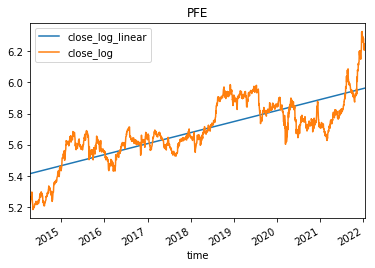

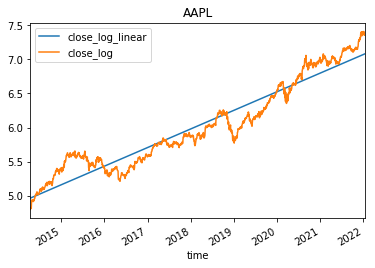

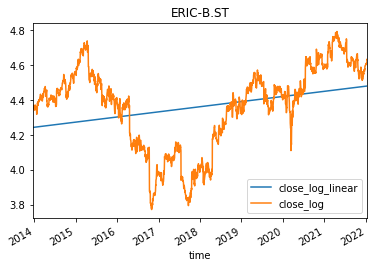

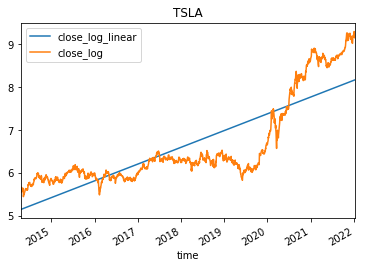

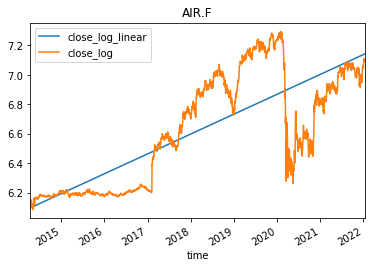

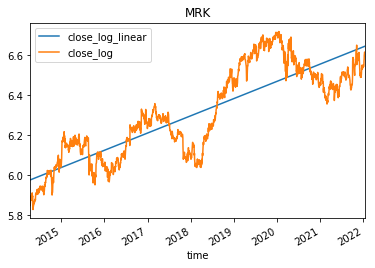

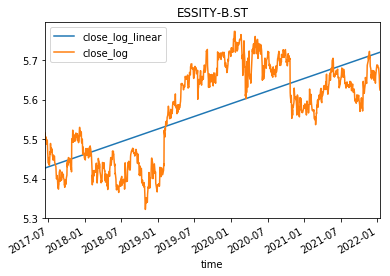

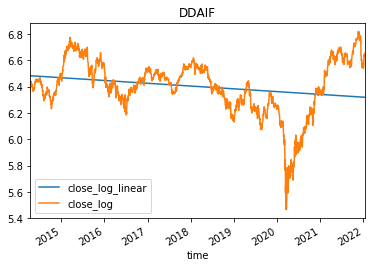

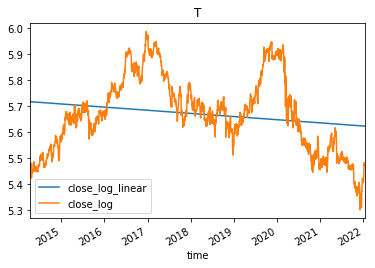

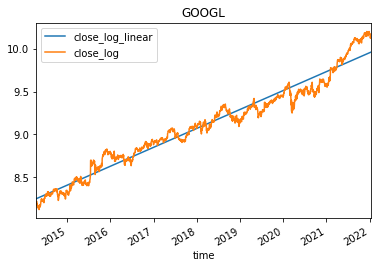

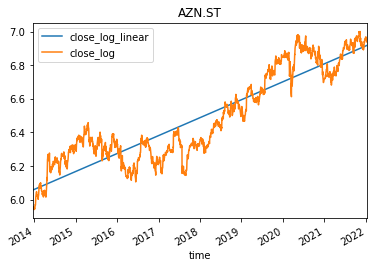

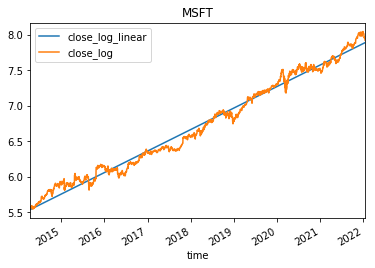

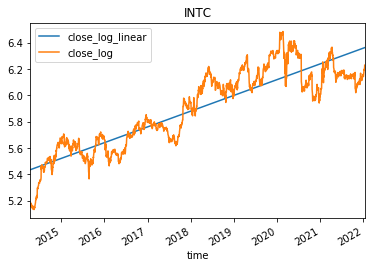

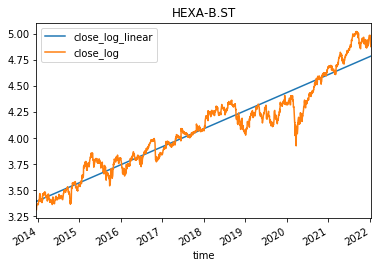

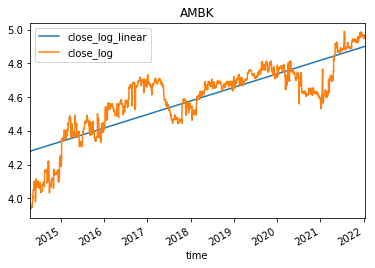

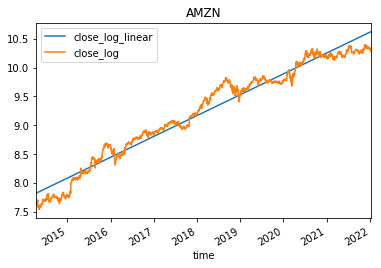

In [69]:
for sec in data_src:
    
    sec['df'].plot(x='time', y=['close_log_linear', 'close_log'], title=sec['name'])

In [70]:
import hashlib
print(all_names)
portfolio_dir = hashlib.md5(all_names.encode('utf-8')).hexdigest()

PFEAAPLERIC-B.STTSLAAIR.FMRKESSITY-B.STDDAIFTGOOGLAZN.STMSFTINTCHEXA-B.STAMBKAMZN


In [71]:
portfolio_dir

'392cc283e0e76b545ec00b364b9abc0d'

In [72]:
data_src[0]['df'].tail()

,close,high,low,open,timestamp,volumn,time,close_ex,close_log,close_log_linear,close_log_error
2019,509.576122,510.033380,499.607744,506.283809,2022-01-07 14:30:00,27686700,2022-01-07 14:30:00,9.14530,6.233579,5.961813,0.271767
2020,509.285252,509.466333,495.701898,504.485777,2022-01-10 14:30:00,34044700,2022-01-10 14:30:00,9.05557,6.233008,5.962392,0.270616
2021,515.891444,522.625622,507.883275,516.437469,2022-01-11 14:30:00,33576600,2022-01-11 14:30:00,9.10022,6.245896,5.962585,0.283311
2022,511.856580,516.464630,505.080015,509.055588,2022-01-12 14:30:00,27608500,2022-01-12 14:30:00,9.03542,6.238044,5.962778,0.275266
2023,495.994083,505.607764,493.280249,504.982457,2022-01-13 20:15:25,19211779,2022-01-13 20:15:25,8.93300,6.206564,5.963018,0.243546


{'name': 'PFE', 'scope': 0.00028029348694379543, 'std': 0.11678735683906064, 'error': 0.24354615185996842}
{'name': 'AAPL', 'scope': 0.0010835608509091868, 'std': 0.1792335774687928, 'error': 0.2732121193779129}
{'name': 'ERIC-B.ST', 'scope': 0.00011736896780149441, 'std': 0.22771469341012357, 'error': 0.15044601182146167}
{'name': 'TSLA', 'scope': 0.0015497193683140895, 'std': 0.5697815640318106, 'error': 0.9823240650807588}
{'name': 'AIR.F', 'scope': 0.0005324617947369244, 'std': 0.22966014163873708, 'error': -0.05287605124176853}
{'name': 'MRK', 'scope': 0.00034198079896378546, 'std': 0.11971511358950812, 'error': -0.04305351298287352}
{'name': 'ESSITY-B.ST', 'scope': 0.00025484093588262296, 'std': 0.08168106694795155, 'error': -0.09553504170985239}
{'name': 'DDAIF', 'scope': -8.39471225772345e-05, 'std': 0.2055432399148091, 'error': 0.33518201698806394}
{'name': 'T', 'scope': -4.8165070699029385e-05, 'std': 0.14153346459288044, 'error': -0.14274615264612933}
{'name': 'GOOGL', 'scop

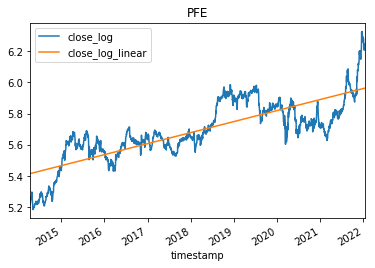

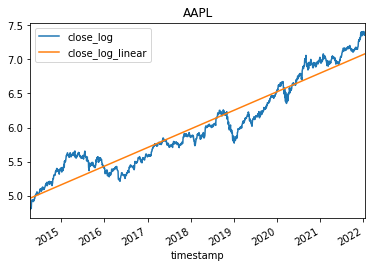

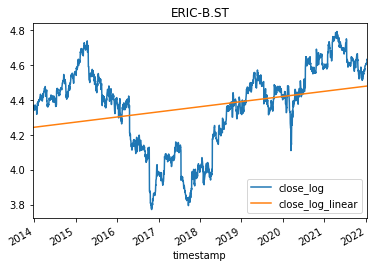

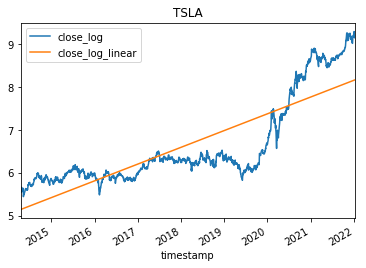

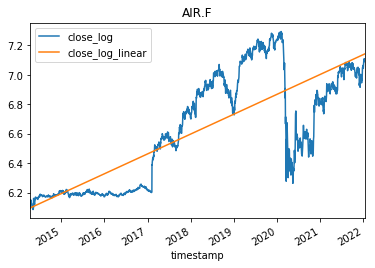

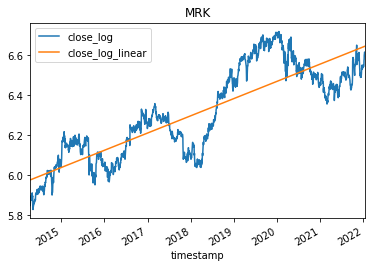

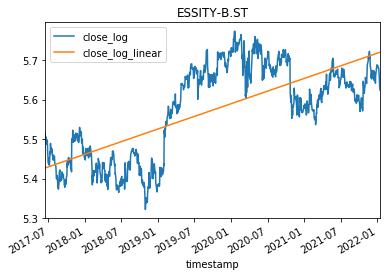

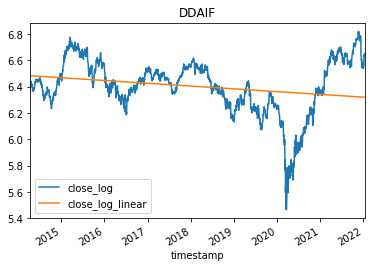

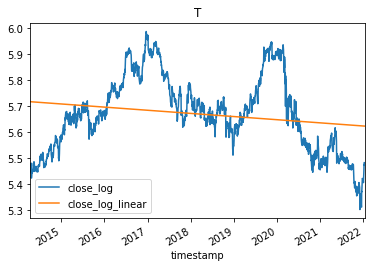

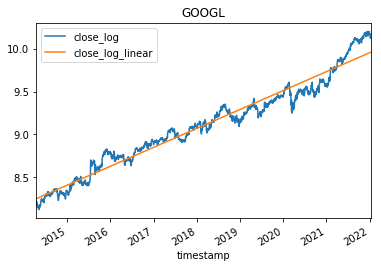

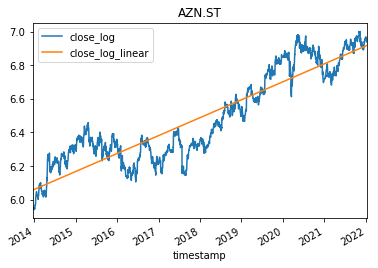

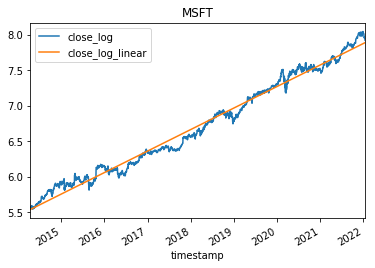

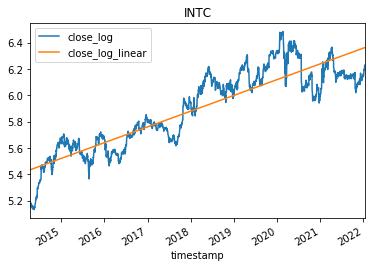

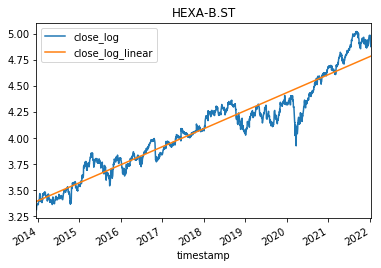

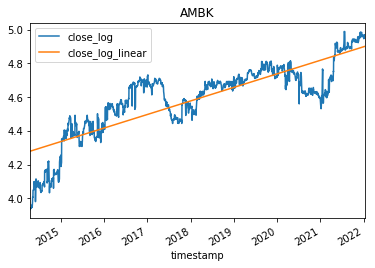

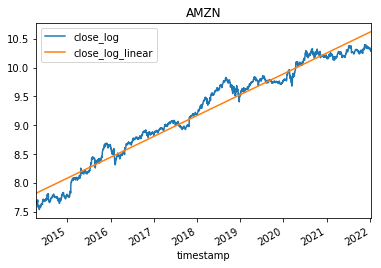

In [73]:
table = []
error_matrix = None
for data in data_src:
    data['df'].plot(x='timestamp', y=['close_log','close_log_linear'], title=data['name'])
    row = {}
    row['name']=data['name']
    row['scope']=data['scope'][0]
    row['std']=data['df']['close_log_error'].std()
    row['error']=data['df']['close_log_error'].values[-1]
    if error_matrix is None:
        error_matrix = data['df'][['time','close_log_error']].rename(columns={'close_log_error': data['name']})
    else:
        error_matrix = pd.merge_asof(error_matrix, data['df'][['time','close_log_error']].rename(columns={'close_log_error': data['name']}), on='time')
    print(row)
    table.append(row)
table = pd.DataFrame(table)

In [53]:
data_src[-1]['df'].tail()

,close,high,low,open,timestamp,volumn,time,close_ex,close_log,close_log_linear,close_log_error
1260,29732.102351,30224.028390,29636.442871,29967.136112,2022-01-07 14:30:00,2329300,2022-01-07 14:30:00,9.14530,10.299983,10.477764,-0.177782
1261,29246.954141,29278.739279,28308.526519,29083.863243,2022-01-10 14:30:00,4389900,2022-01-10 14:30:00,9.05557,10.283531,10.480190,-0.196659
1262,30096.610600,30276.431030,29248.379474,29393.709717,2022-01-11 14:30:00,3140300,2022-01-11 14:30:00,9.10022,10.312168,10.480998,-0.168830
1263,29854.293049,30156.258299,29711.535171,30101.503122,2022-01-12 14:30:00,2501500,2022-01-12 14:30:00,9.03542,10.304084,10.481807,-0.177723
1264,29207.267828,30037.622082,29194.528679,29862.154923,2022-01-13 20:15:21,1825035,2022-01-13 20:15:21,9.03542,10.282173,10.482809,-0.200636


In [74]:
table.tail()

,error,name,scope,std
11,0.036369,MSFT,0.001204,0.085909
12,-0.166001,INTC,0.000476,0.136969
13,0.118858,HEXA-B.ST,0.000689,0.118057
14,0.057205,AMBK,0.000319,0.116963
15,-0.343153,AMZN,0.001437,0.157397


In [75]:
error_matrix.tail()

,time,PFE,AAPL,ERIC-B.ST,TSLA,AIR.F,MRK,ESSITY-B.ST,DDAIF,T,GOOGL,AZN.ST,MSFT,INTC,HEXA-B.ST,AMBK,AMZN
1946,2022-01-07 14:30:00,0.271767,0.286422,0.127887,0.984149,-0.036842,-0.043347,-0.037964,0.318007,-0.140356,0.170707,0.025317,0.079145,-0.170965,0.134014,0.070392,-0.319165
1947,2022-01-10 14:30:00,0.270616,0.274438,0.137965,1.000976,-0.032005,-0.028462,-0.057073,0.308680,-0.143671,0.171019,0.019597,0.067528,-0.149225,0.089591,0.059873,-0.338587
1948,2022-01-11 14:30:00,0.283311,0.295255,0.147707,1.010745,-0.036139,-0.032314,-0.070887,0.304280,-0.143265,0.182993,0.034720,0.073873,-0.132036,0.113279,0.064571,-0.310940
1949,2022-01-12 14:30:00,0.275266,0.289929,0.154640,1.041068,-0.041788,-0.045467,-0.087750,0.314196,-0.146210,0.187295,0.033471,0.076288,-0.142555,0.125777,0.057205,-0.320014
1950,2022-01-13 20:15:25,0.243546,0.273212,0.150446,0.982324,-0.052876,-0.043054,-0.095535,0.335182,-0.142746,0.168281,0.027702,0.036369,-0.166001,0.118858,0.057205,-0.343153


In [76]:
error_matrix.cov()

,PFE,AAPL,ERIC-B.ST,TSLA,AIR.F,MRK,ESSITY-B.ST,DDAIF,T,GOOGL,AZN.ST,MSFT,INTC,HEXA-B.ST,AMBK,AMZN
PFE,0.013639,-0.001587,-0.000365,-0.024941,0.009248,0.006664,-0.000229,0.004161,0.004458,0.003111,0.001103,0.000882,0.004561,0.001951,0.008213,0.006128
AAPL,-0.001587,0.032125,0.025787,0.076086,-0.012631,-0.002171,-0.001619,0.014430,-0.012229,0.003993,0.011604,0.010026,-0.004533,0.009722,-0.006394,-0.010102
ERIC-B.ST,-0.000365,0.025787,0.052448,0.061992,-0.005915,0.003324,0.000517,0.005906,-0.018291,-0.001214,0.019081,0.012429,-0.002773,0.003170,-0.010483,-0.014858
TSLA,-0.024941,0.076086,0.061992,0.324651,-0.076387,-0.034007,-0.021241,0.051067,-0.054416,0.017307,0.014662,0.016474,-0.045575,0.033186,-0.027483,-0.046013
AIR.F,0.009248,-0.012631,-0.005915,-0.076387,0.052883,0.007169,0.001837,0.006452,0.007538,0.000688,-0.001874,-0.001510,0.013357,0.001278,0.003051,0.005176
MRK,0.006664,-0.002171,0.003324,-0.034007,0.007169,0.014332,0.006935,-0.010138,0.008243,-0.003672,0.006172,0.002607,0.007777,-0.006756,0.004021,0.001784
ESSITY-B.ST,-0.000229,-0.001619,0.000517,-0.021241,0.001837,0.006935,0.006702,-0.010060,0.006745,-0.003111,0.004606,0.002257,0.004785,-0.006601,0.000547,-0.000580
DDAIF,0.004161,0.014430,0.005906,0.051067,0.006452,-0.010138,-0.010060,0.042248,-0.007934,0.013722,-0.004054,0.000484,-0.008429,0.020662,0.003965,-0.004851
T,0.004458,-0.012229,-0.018291,-0.054416,0.007538,0.008243,0.006745,-0.007934,0.020032,-0.000735,-0.004439,-0.003909,0.008875,-0.005256,0.010376,0.009661
GOOGL,0.003111,0.003993,-0.001214,0.017307,0.000688,-0.003672,-0.003111,0.013722,-0.000735,0.010123,-0.001355,0.001603,-0.002827,0.007591,0.004992,0.000631


In [77]:
table['annual']=table['scope']*252-table['error']

In [78]:
table

,error,name,scope,std,annual
0,0.243546,PFE,0.000280,0.116787,-0.172912
1,0.273212,AAPL,0.001084,0.179234,-0.000155
2,0.150446,ERIC-B.ST,0.000117,0.227715,-0.120869
3,0.982324,TSLA,0.001550,0.569782,-0.591795
4,-0.052876,AIR.F,0.000532,0.229660,0.187056
5,-0.043054,MRK,0.000342,0.119715,0.129233
6,-0.095535,ESSITY-B.ST,0.000255,0.081681,0.159755
7,0.335182,DDAIF,-0.000084,0.205543,-0.356337
8,-0.142746,T,-0.000048,0.141533,0.130609
9,0.168281,GOOGL,0.000879,0.100613,0.053146


In [79]:
def get_exp(weights):
    weights = np.array(weights)
    annual_profits = table['annual'].to_numpy()
    res = np.matmul(weights, annual_profits)
    return np.matmul(weights, annual_profits)

In [80]:
def get_std(weights):
    weights = np.array(weights)
    cov_m = np.array(error_matrix.cov())
    res = np.sqrt(np.matmul(np.matmul(weights, cov_m), np.transpose(weights)))
    return np.sqrt(np.matmul(np.matmul(weights, cov_m), np.transpose(weights)))

In [81]:
def get_sharpe(weights):
    print(weights)
    res = -get_exp(weights)/get_std(weights)
    print(res)
    return res

In [82]:
num_stocks=len(table)
bnds = []
init = []
for i in range(num_stocks):
    bnds.append((0,0.3))
    init.append(1/num_stocks)

bnds = tuple(bnds)
init = tuple(init)

In [83]:
from scipy.optimize import minimize

cons = {'type': 'eq', 'fun': lambda x:  1-np.sum(x)}
res = minimize(get_sharpe, init, method='SLSQP', bounds=bnds,
               constraints=cons)

[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
-0.8814985196567154
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]
-0.8814985196567154
[0.06250001 0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ]
-0.8814984673612936
[0.0625     0.06250001 0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ]
-0.8814984884703487
[0.0625     0.0625     0.06250001 0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625    ]
-0.8814984584450795
[0.0625     0.0625     0.0625     0.06250001 0.0625     0.0625
 0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
 0.0625     0.0625     0.062

-6.702957044290557
[4.79152833e-13 3.65639297e-13 3.37467761e-13 2.76869359e-02
 5.37118623e-02 2.03617842e-13 3.00000000e-01 1.29423048e-13
 1.93383690e-13 4.43986980e-14 2.92821426e-13 4.52741972e-02
 5.60345233e-13 2.73327005e-01 1.20544629e-13 3.00000000e-01]
-5.514998285764441
[4.79152833e-14 3.65639297e-14 3.37467761e-14 4.56846740e-02
 6.12233921e-02 2.03617842e-14 2.93197689e-01 1.29423048e-14
 1.93383690e-14 4.43986980e-15 2.92821426e-14 2.32611367e-01
 1.19072963e-13 6.72828781e-02 1.20544629e-14 3.00000000e-01]
-6.698920474880045
[1.70445935e-14 1.30066499e-14 1.20045221e-14 4.69730650e-02
 6.17611145e-02 7.24316566e-15 2.92710737e-01 4.60388228e-15
 6.87911278e-15 1.57936614e-15 1.04163470e-14 2.46022137e-01
 8.74839250e-14 5.25329466e-02 4.28805603e-15 3.00000000e-01]
-6.704750644693182
[1.70445935e-14 1.30066499e-14 1.20045221e-14 4.69730650e-02
 6.17611145e-02 7.24316566e-15 2.92710737e-01 4.60388228e-15
 6.87911278e-15 1.57936614e-15 1.04163470e-14 2.46022137e-01
 8.748

In [84]:
table

,error,name,scope,std,annual
0,0.243546,PFE,0.000280,0.116787,-0.172912
1,0.273212,AAPL,0.001084,0.179234,-0.000155
2,0.150446,ERIC-B.ST,0.000117,0.227715,-0.120869
3,0.982324,TSLA,0.001550,0.569782,-0.591795
4,-0.052876,AIR.F,0.000532,0.229660,0.187056
5,-0.043054,MRK,0.000342,0.119715,0.129233
6,-0.095535,ESSITY-B.ST,0.000255,0.081681,0.159755
7,0.335182,DDAIF,-0.000084,0.205543,-0.356337
8,-0.142746,T,-0.000048,0.141533,0.130609
9,0.168281,GOOGL,0.000879,0.100613,0.053146


In [85]:
res

     fun: -6.709765478903531
     jac: array([ 8.39485979,  6.99237907,  7.09210688,  0.70402402,  0.71682239,
        2.61259329,  0.11393839,  6.33575845,  2.19373912,  1.68470627,
        4.54006708,  0.72066206,  2.50882864,  0.71895707,  2.09532118,
       -1.0710454 ])
 message: 'Optimization terminated successfully.'
    nfev: 150
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([3.57454910e-15, 0.00000000e+00, 5.79391605e-15, 4.81741015e-02,
       6.39429666e-02, 7.82850646e-15, 3.00000000e-01, 2.80072081e-15,
       2.48612689e-15, 0.00000000e+00, 2.74476834e-15, 2.37279499e-01,
       1.05219299e-14, 5.06034332e-02, 7.37475433e-16, 3.00000000e-01])

In [86]:
table['percentage']=res.x
table.style.format({'percentage': '{:.2f}'})

,error,name,scope,std,annual,percentage
0,0.243546,PFE,0.000280293,0.116787,-0.172912,0.00
1,0.273212,AAPL,0.00108356,0.179234,-0.000154785,0.00
2,0.150446,ERIC-B.ST,0.000117369,0.227715,-0.120869,0.00
3,0.982324,TSLA,0.00154972,0.569782,-0.591795,0.05
4,-0.0528761,AIR.F,0.000532462,0.22966,0.187056,0.06
5,-0.0430535,MRK,0.000341981,0.119715,0.129233,0.00
6,-0.095535,ESSITY-B.ST,0.000254841,0.0816811,0.159755,0.30
7,0.335182,DDAIF,-8.39471e-05,0.205543,-0.356337,0.00
8,-0.142746,T,-4.81651e-05,0.141533,0.130609,0.00
9,0.168281,GOOGL,0.000878677,0.100613,0.0531456,0.00


In [40]:
table

,error,name,scope,std,annual,percentage
0,0.308735,PFE,0.000225,0.119739,-0.252099,6.479693e-14
1,0.131588,AAPL,0.001384,0.127716,0.217150,3.981416e-14
2,-0.126561,ERIC-B.ST,0.000628,0.111420,0.284737,1.194442e-01
3,0.468602,TSLA,0.002673,0.529676,0.205046,4.826058e-02
4,0.106034,AIR.F,0.000187,0.236449,-0.058870,1.066338e-02
5,-0.035601,MRK,0.000326,0.137946,0.117696,8.405034e-15
6,-0.097662,ESSITY-B.ST,0.000255,0.081683,0.161872,3.000000e-01
7,0.274087,DDAIF,0.000002,0.237231,-0.273699,2.776704e-16
8,-0.028178,T,-0.000254,0.112011,-0.035931,3.389383e-14
9,0.171427,GOOGL,0.000923,0.110442,0.061265,0.000000e+00


In [41]:
get_exp(res.x)

0.27912965652499455

In [42]:
get_std(res.x)

0.044371482077492745

In [43]:
get_sharpe(res.x)

[6.47969343e-14 3.98141552e-14 1.19444174e-01 4.82605819e-02
 1.06633807e-02 8.40503438e-15 3.00000000e-01 2.77670386e-16
 3.38938323e-14 0.00000000e+00 2.42061984e-03 3.00000000e-01
 2.46363808e-14 5.37255832e-02 1.55836603e-14 1.65485661e-01]
-6.290744492994565


-6.290744492994565

In [44]:
# [{timestamp:1231,sharpe: 6, portofolio: 
# [{symbol:AAPL: percentage:0.21}, {{symbol:AAPL: percentage:0.21}}]}]

def createDir(dir):
    isExist = os.path.exists(dir)
    if not isExist:
      # Create a new directory because it does not exist 
      os.makedirs(path)



In [45]:
createDir('../result/')

NameError: name 'path' is not defined